In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from collections import defaultdict

import numpy as np

import lsst.daf.butler as dB
import lsst.cp.verify.notebooks.utils as utils
import lsst.afw.display as afwDisplay
plt.rcParams['figure.figsize'] = (8, 8)

In [2]:
# Which calibration type to analyse.
calibType = 'crosstalk'
detectorId = 0

# This cell should be edited to match the data to be inspected.
afwDisplay.setDefaultBackend("astrowidgets")
cameraName = 'LATISS'
genCollection = 'u/czw/DM-30170/crosstalkGen.20220322a'
correctedCollection = 'u/czw/DM-30170/verifyCrosstalk.20220322a'

In [3]:
# Get butler and camera
butler = dB.Butler("/repo/main/", collections=[genCollection, correctedCollection])
camera = butler.get('camera', instrument=cameraName)

In [4]:
crosstalk = butler.get(calibType, instrument=cameraName, 
                       detector=detectorId, collections=genCollection)
residualCrosstalk = butler.get('verifyCrosstalk', instrument=cameraName, 
                               detector=detectorId, collections=correctedCollection)

In [7]:
print("Crosstalk creation:", crosstalk.getMetadata().toDict().get('CALIBDATE', "Bad header"))
print("Residual creation: ", residualCrosstalk.getMetadata().toDict().get('CALIBDATE', "Bad header"))

Crosstalk creation: 2022-03-22T18:40:52.562456
Residual creation:  2022-03-23T14:37:25.902017


In [8]:
runStats = butler.get('verifyCrosstalkStats', instrument=cameraName, collections=correctedCollection)
runSuccess = runStats.pop('SUCCESS')

In [9]:
# Display summary table of tests and failure counts.
utils.failureTable(runStats)

Detector 0,Detector,1


In [10]:
display = afwDisplay.Display(dims=(1000, 1000))
display.embed()

ImageWidget(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\x…

In [11]:
# This block allows the residual images to be scanned for concerns.
blinkResiduals = True
if blinkResiduals:
    continueDisplay = True
    skipNumber = 0
    for datasetRef in butler.registry.queryDatasets('verifyCrosstalkProc'):
        # Do it this way, because runStats doesn't retain exposure info.
        if skipNumber > 0:
            skipNumber -= 1
            continue
        dataId = datasetRef.dataId
        original = butler.get('cpCrosstalkProc', dataId=dataId)
        residual = butler.get(datasetRef)
        detStats = {}
        display.mtv(original)
        display.scale('linear', 'zscale', None)
        
        continueDisplay, skipNumber = utils.interactiveBlock(f"Orig: {dataId['exposure']} {dataId['detector']}", 
                                                             detStats)
        display.mtv(residual)
        display.scale('linear', 'zscale', None)
        continueDisplay, skipNumber = utils.interactiveBlock(f"Resid: {dataId['exposure']} {dataId['detector']}", 
                                                             detStats)

        
        if continueDisplay is False:
            break


Orig: 2020021900288 0 Continue? [h, c, q, p, #]q
Resid: 2020021900288 0 Continue? [h, c, q, p, #]q


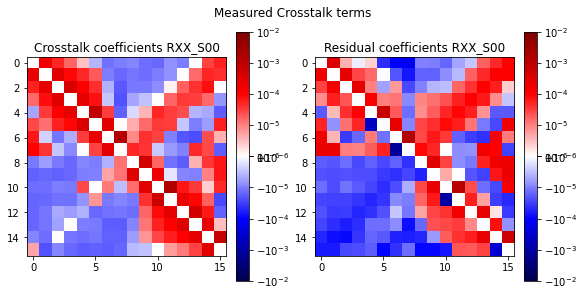

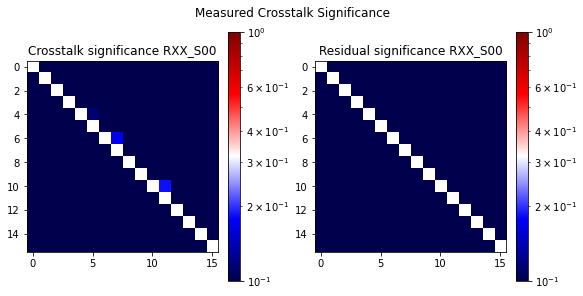

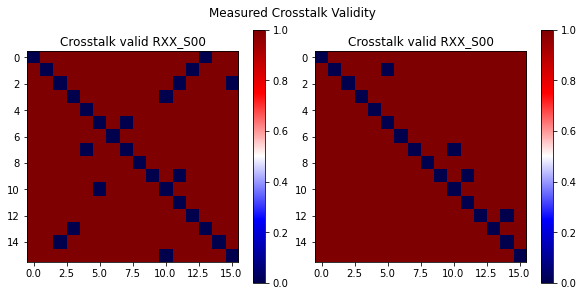

In [12]:
# Plot raw crosstalk values

detector = camera[detectorId]
detName = detector.getName()

fig, axes = plt.subplots(nrows=1, ncols=2,
                         sharex=True, sharey=False, figsize=[8.0, 4.0], constrained_layout=True)
pcm = axes[0].imshow(crosstalk.coeffs, cmap='seismic', 
                     norm=colors.SymLogNorm(linthresh=1e-6, linscale=1e-7, vmin=-1e-2, vmax=1e-2))
axes[0].set_title(f"Crosstalk coefficients {detName}")
fig.colorbar(pcm, ax=axes[0])

pcm = axes[1].imshow(residualCrosstalk.coeffs, cmap='seismic',
                     norm=colors.SymLogNorm(linthresh=1e-6, linscale=1e-7, vmin=-1e-2, vmax=1e-2))
axes[1].set_title(f"Residual coefficients {detName}")
fig.colorbar(pcm, ax=axes[1])

fig.suptitle(f"Measured Crosstalk terms")
plt.show()

###

fig, axes = plt.subplots(nrows=1, ncols=2,
                         sharex=True, sharey=False, figsize=[8.0, 4.0], constrained_layout=True)
pcm = axes[0].imshow(np.abs(crosstalk.coeffs / crosstalk.coeffErr / np.sqrt(crosstalk.coeffNum)), 
                     cmap='seismic', 
                     norm=colors.LogNorm(vmin=1e-1, vmax=1e0))
axes[0].set_title(f"Crosstalk significance {detName}")
fig.colorbar(pcm, ax=axes[0])

pcm = axes[1].imshow(np.abs(residualCrosstalk.coeffs / residualCrosstalk.coeffErr / np.sqrt(residualCrosstalk.coeffNum)), 
                     cmap='seismic',
                     norm=colors.LogNorm(vmin=1e-1, vmax=1e0))
axes[1].set_title(f"Residual significance {detName}")
fig.colorbar(pcm, ax=axes[1])

fig.suptitle(f"Measured Crosstalk Significance")
plt.show()

###

fig, axes = plt.subplots(nrows=1, ncols=2,
                         sharex=True, sharey=False, figsize=[8.0, 4.0], constrained_layout=True)
pcm = axes[0].imshow(crosstalk.coeffValid, cmap='seismic')
axes[0].set_title(f"Crosstalk valid {detName}")
fig.colorbar(pcm, ax=axes[0])

pcm = axes[1].imshow(residualCrosstalk.coeffValid, cmap='seismic')
axes[1].set_title(f"Crosstalk valid {detName}")
fig.colorbar(pcm, ax=axes[1])

fig.suptitle(f"Measured Crosstalk Validity")
plt.show()

In [13]:
# Load data for further study.  This cell is very slow.
XX = np.arange(-20, -11, 0.1)

for detector in camera:
    ratioDataRefs = butler.registry.queryDatasets('cpCrosstalkRatio', 
                                                  detector=detector.getId(), collections=genCollection)
    
    fullSet = defaultdict(lambda: defaultdict(list))
    residualSet = defaultdict(lambda: defaultdict(list))

    fluxSet = defaultdict(list)
    fluxResidualSet = defaultdict(list)
    
    for dataRef in ratioDataRefs:
        print(dataRef)
        ratioData = butler.get('cpCrosstalkRatio', dataId=dataRef.dataId, collections=genCollection)
        fluxData = butler.get('crosstalkFluxes', dataId=dataRef.dataId, collections=genCollection)
        residualData = butler.get('verifyCrosstalkRatio', dataId=dataRef.dataId,
                                  collections=correctedCollection)
        residualFluxData = butler.get('crosstalkFluxes', dataId=dataRef.dataId,
                                  collections=correctedCollection)
        # fluxData = butler.get('crosstalkFluxes', dataId=dataRef.dataId)
        
        for targetDetector, sourceData in ratioData.items():
            for sourceDetector, ratios in sourceData.items():
                for targetAmp, ampData in ratios.items():
                    for sourceAmp, values in ampData.items():
                        fullSet[targetAmp][sourceAmp].extend(values)
                            
        for targetDetector, sourceData in residualData.items():
            for sourceDetector, ratios in sourceData.items():
                for targetAmp, ampData in ratios.items():
                    for sourceAmp, values in ampData.items():
                         residualSet[targetAmp][sourceAmp].extend(values)
                            
        for targetDetector, sourceData in fluxData.items():
            for sourceAmp, values in sourceData.items():
                fluxSet[sourceAmp].extend(values)
                    
        for targetDetector, sourceData in residualFluxData.items():
            for sourceAmp, values in sourceData.items():
                fluxResidualSet[sourceAmp].extend(values)

cpCrosstalkRatio@{instrument: 'LATISS', detector: 0, exposure: 2020021900288, ...}, sc=StructuredDataDict] (id=8b9041da-6117-4ced-9380-9ae05b61f9a6)
cpCrosstalkRatio@{instrument: 'LATISS', detector: 0, exposure: 2020021900289, ...}, sc=StructuredDataDict] (id=3f51a481-005d-4960-9884-756c84885ca7)
cpCrosstalkRatio@{instrument: 'LATISS', detector: 0, exposure: 2020021900290, ...}, sc=StructuredDataDict] (id=990e3208-90eb-49b6-80be-10f8b4379a7d)
cpCrosstalkRatio@{instrument: 'LATISS', detector: 0, exposure: 2020021900291, ...}, sc=StructuredDataDict] (id=ed2db999-7ef2-42c8-9607-ffe19dc68d6f)
cpCrosstalkRatio@{instrument: 'LATISS', detector: 0, exposure: 2020021900292, ...}, sc=StructuredDataDict] (id=3cbafdb9-5705-4a5b-b04a-fae5ca6e3277)
cpCrosstalkRatio@{instrument: 'LATISS', detector: 0, exposure: 2020021900293, ...}, sc=StructuredDataDict] (id=f8ffc55b-2cd1-4d07-b206-5959a60defe1)
cpCrosstalkRatio@{instrument: 'LATISS', detector: 0, exposure: 2020021900294, ...}, sc=StructuredDataDict]

cpCrosstalkRatio@{instrument: 'LATISS', detector: 0, exposure: 2021021800694, ...}, sc=StructuredDataDict] (id=96258243-a3aa-4a92-ab6c-4e241ae0dc69)
cpCrosstalkRatio@{instrument: 'LATISS', detector: 0, exposure: 2021021800695, ...}, sc=StructuredDataDict] (id=ea224181-0856-4901-b012-ddd8b6eb779a)
cpCrosstalkRatio@{instrument: 'LATISS', detector: 0, exposure: 2021021800696, ...}, sc=StructuredDataDict] (id=da8d8bd5-c22d-44c3-96b4-d74ddcd09293)
cpCrosstalkRatio@{instrument: 'LATISS', detector: 0, exposure: 2021021800697, ...}, sc=StructuredDataDict] (id=5910e046-4648-4092-83ce-6253275f4b98)
cpCrosstalkRatio@{instrument: 'LATISS', detector: 0, exposure: 2021021800698, ...}, sc=StructuredDataDict] (id=b8cba66e-3c60-44d7-aa51-3adb86965335)
cpCrosstalkRatio@{instrument: 'LATISS', detector: 0, exposure: 2021021800699, ...}, sc=StructuredDataDict] (id=f1ef8239-1902-4cc3-8e19-9f3212c06e42)
cpCrosstalkRatio@{instrument: 'LATISS', detector: 0, exposure: 2021021800700, ...}, sc=StructuredDataDict]

In [14]:
# This is a helper function for trimming the far wings from the CT signal.
rejSigma = 2.0

def maskValues(inValues):
    inValues = np.array(inValues)
    if len(inValues) < 3:
        return inValues
    for rej in range(3):
        lo, med, hi = np.percentile(inValues, [25.0, 50.0, 75.0])
        sigma = 0.741*(hi - lo)
        valuesMask = np.abs(inValues - med) < rejSigma*sigma
        inValues = inValues[valuesMask]
    return inValues

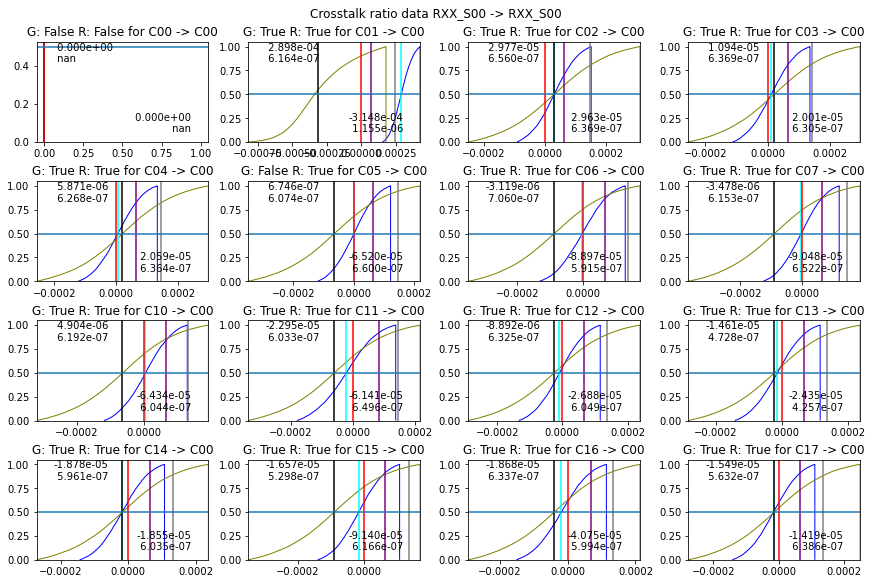

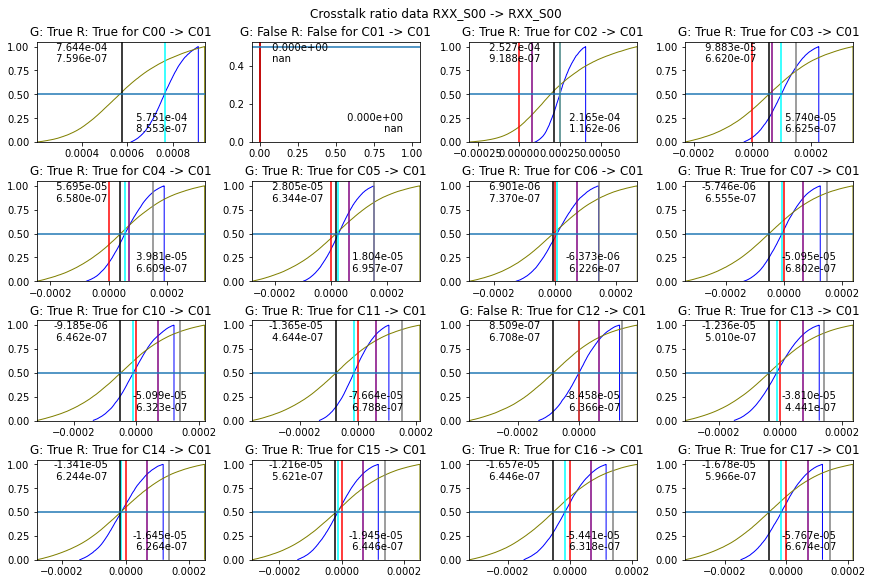

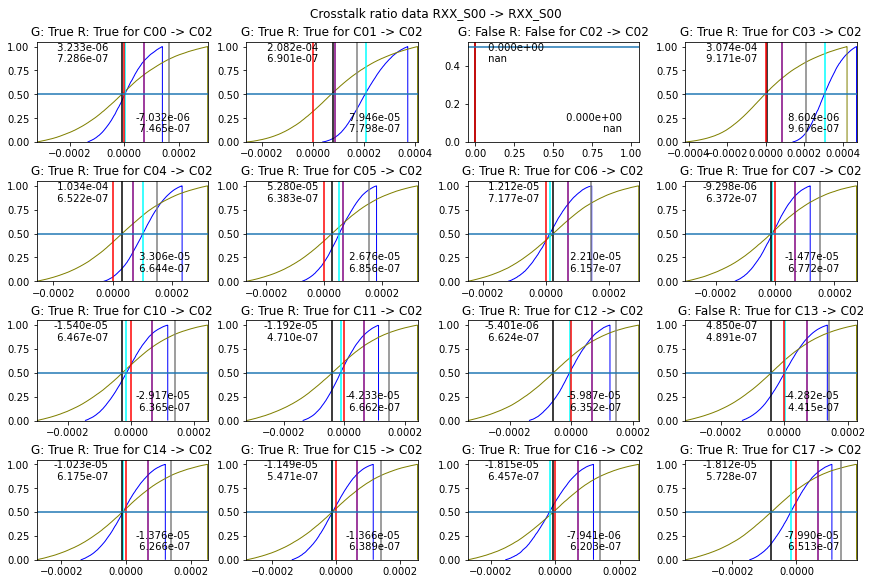

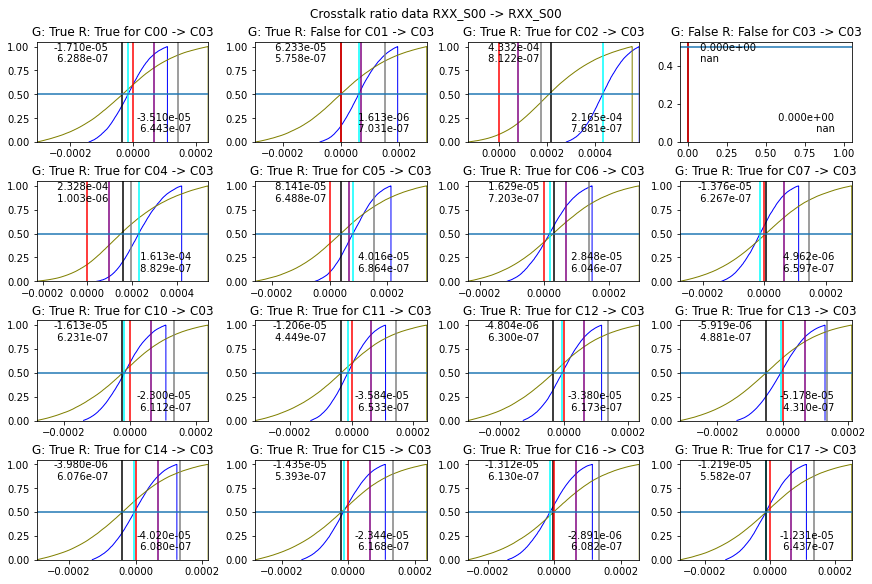

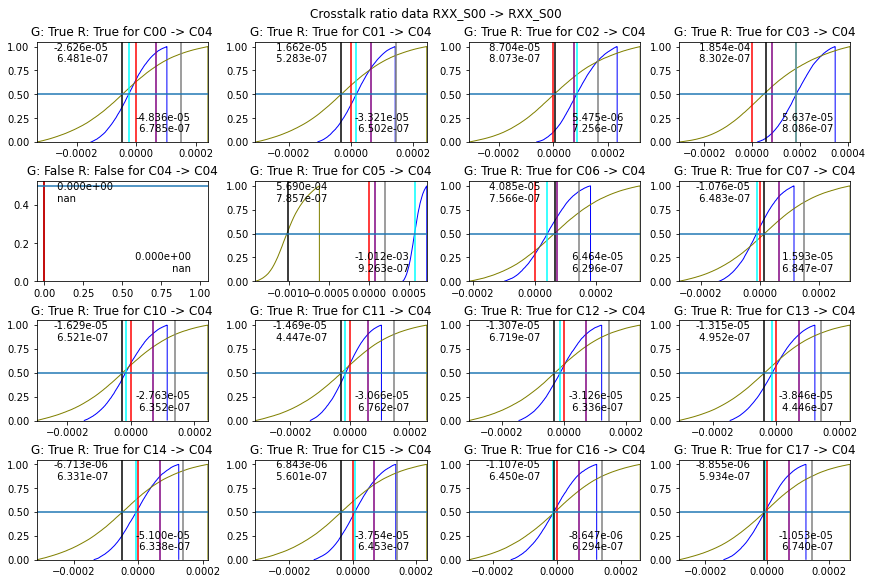

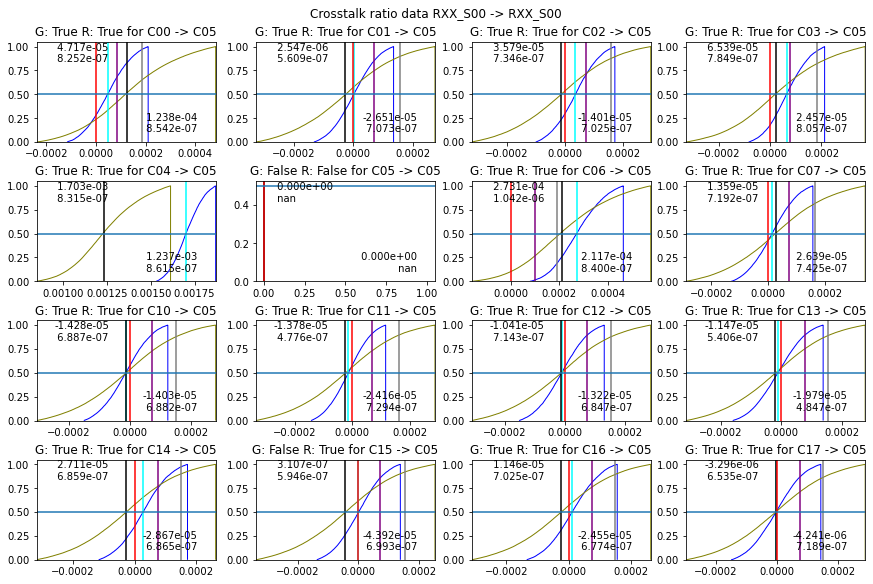

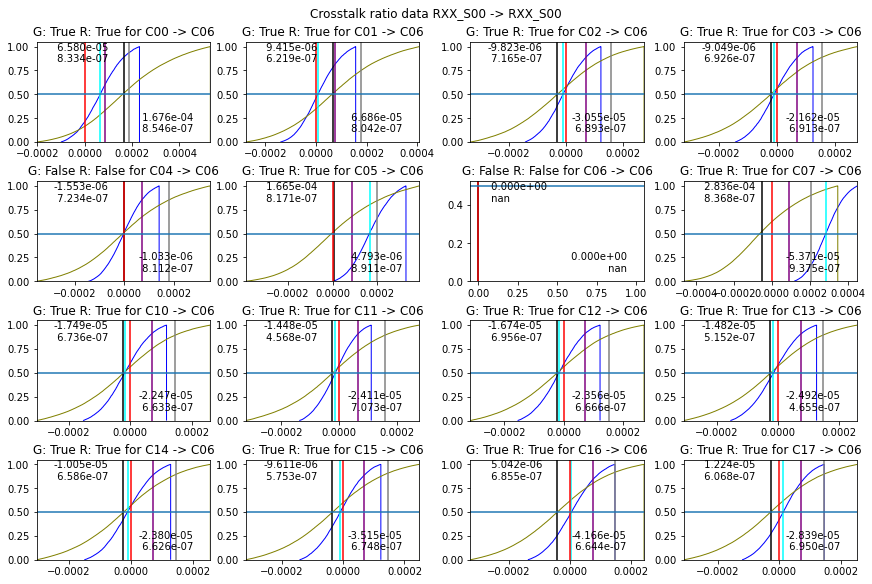

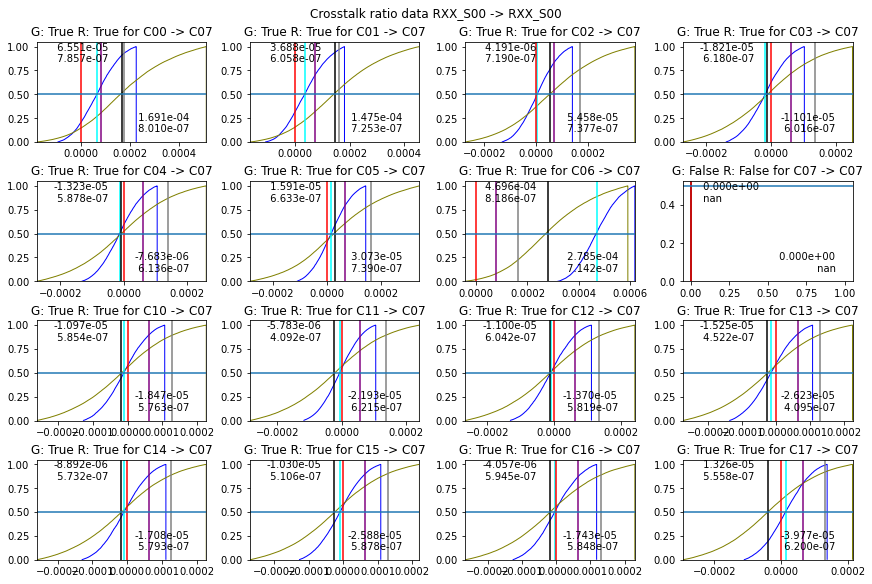

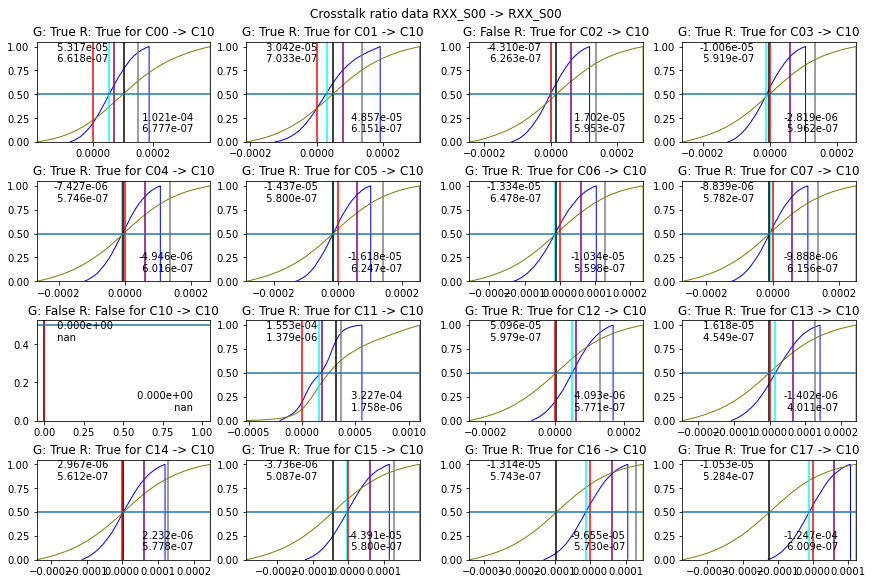

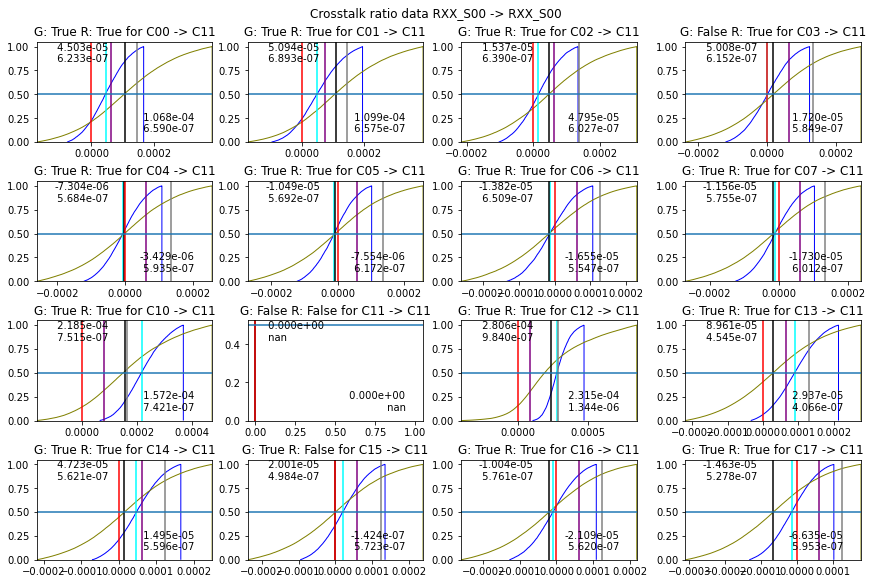

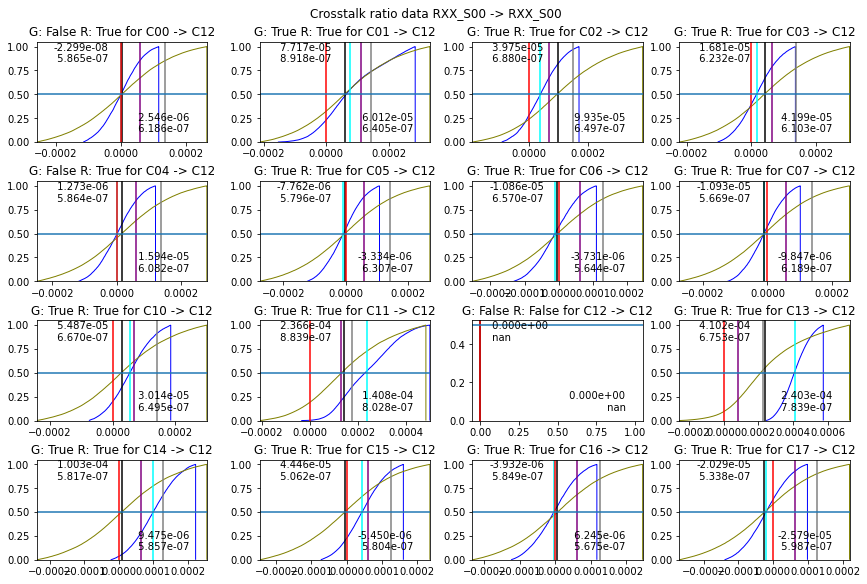

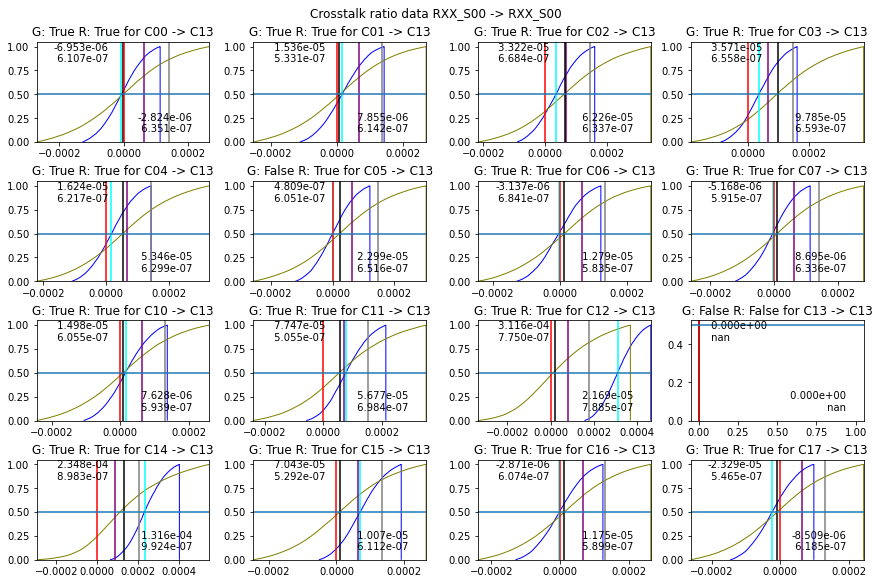

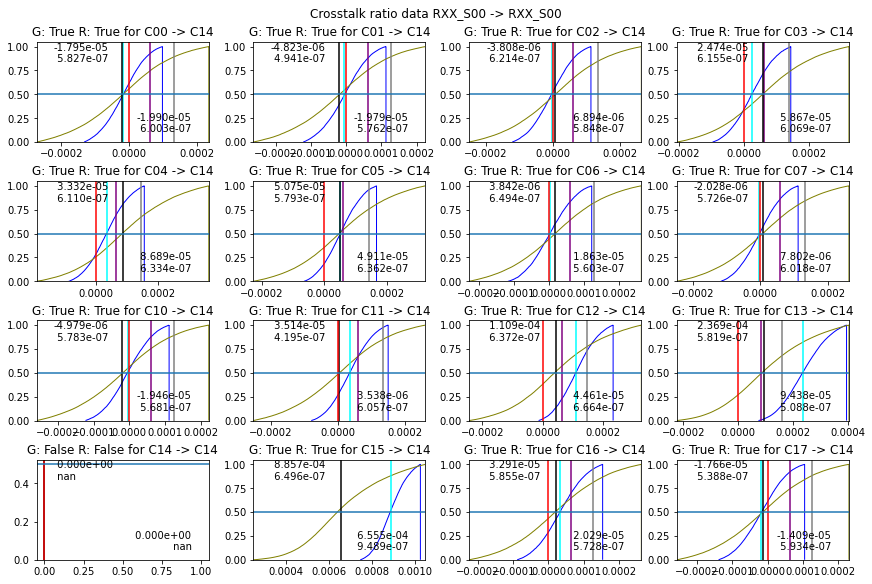

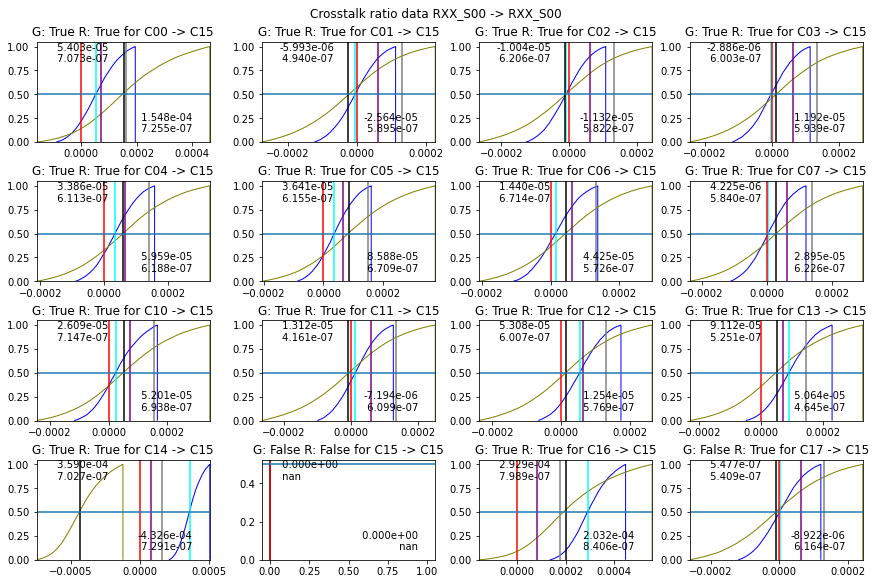

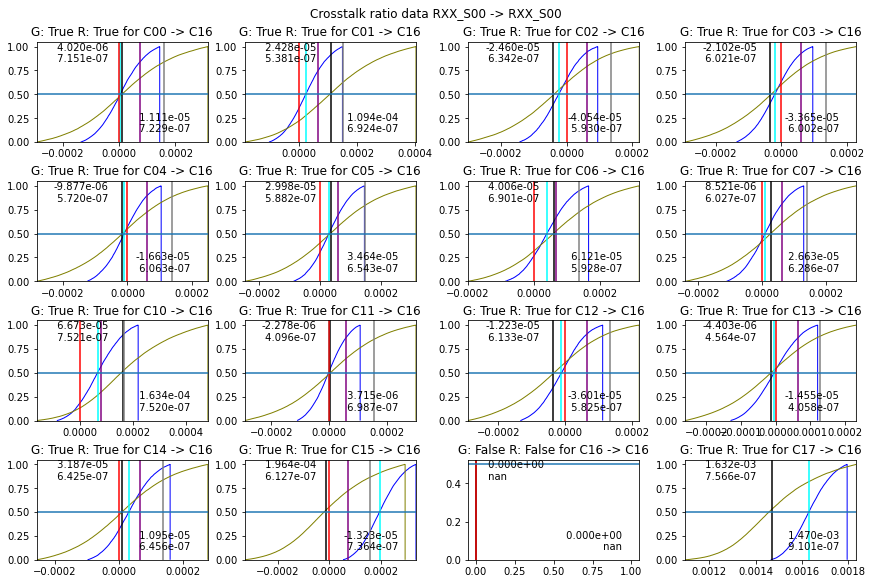

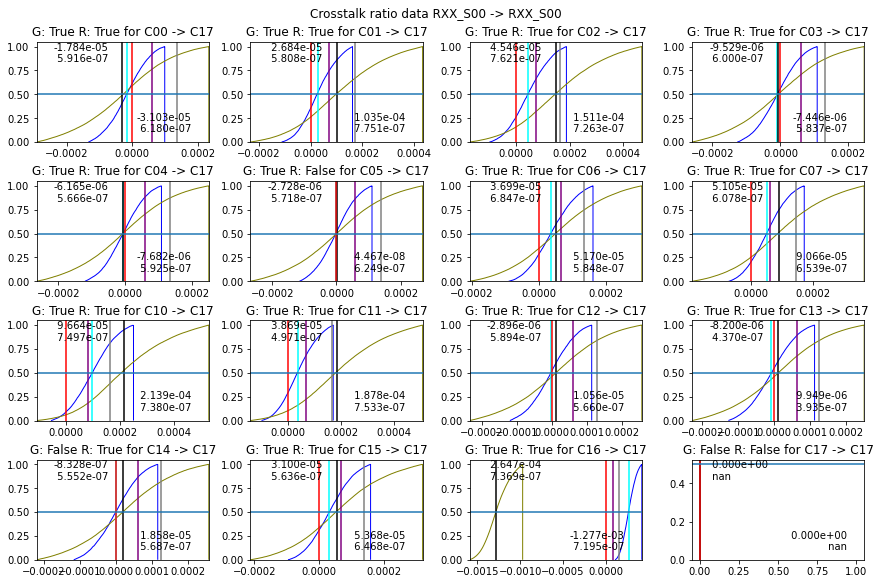

In [15]:
# Plot pre- and post- correction ratio values, along with vertical lines for the quoted coefficients.
cdf = True

ordering = [amp.getName() for amp in detector]
with np.errstate(invalid='ignore', divide='ignore'):
    for targetAmp, targetValues in fullSet.items():
        fig, axes = plt.subplots(nrows=4, ncols=4,
                                 sharex=False, sharey=False, figsize=[12.0, 8.0], 
                                 constrained_layout=True)
        axIterator = 0
        for sourceAmp, values in targetValues.items():
            sourceIt = ordering.index(sourceAmp)
            targetIt = ordering.index(targetAmp)
        
            CTmean = crosstalk.coeffs[targetIt][sourceIt]
            CTerr = crosstalk.coeffErr[targetIt][sourceIt]
            CTN = crosstalk.coeffNum[targetIt][sourceIt]
            CTValid = crosstalk.coeffValid[targetIt][sourceIt]
        
            CTResidMean = residualCrosstalk.coeffs[targetIt][sourceIt]
            CTResidErr = residualCrosstalk.coeffErr[targetIt][sourceIt]
            CTResidN = residualCrosstalk.coeffNum[targetIt][sourceIt]
            CTResidValid = residualCrosstalk.coeffValid[targetIt][sourceIt]
        
            residualValues = residualSet[targetAmp][sourceAmp]
            nBin = int(len(values)) if cdf else 25
        
            if nBin <= 0:
                nBin = 25
            axTuple = (axIterator // 4, axIterator % 4)
        
            values = maskValues(values)
            residualValues = maskValues(residualValues)
            axes[axTuple].hist(values, bins=nBin, color="blue",
                               density=cdf, histtype='step', cumulative=cdf)
            axes[axTuple].hist(residualValues, bins=nBin, color="olive",
                               density=cdf, histtype='step', cumulative=cdf)

            axes[axTuple].axvline(CTmean, c='cyan')
            axes[axTuple].axvline(1 * CTerr, c='purple')

            axes[axTuple].axvline(CTResidMean, c='black')
            axes[axTuple].axvline(1 * CTResidErr, c='grey')
            axes[axTuple].axvline(0.0, c='red')
            axes[axTuple].axline((0.0, 0.5), slope=0.0)
        
            axes[axTuple].text(0.1, 0.8, 
                               f"{CTmean: 1.3e}\n{CTerr / np.sqrt(CTN): 1.3e}",
                               transform=axes[axTuple].transAxes,
                               horizontalalignment='left')
            axes[axTuple].text(0.9, 0.1, f"{CTResidMean: 1.3e}\n{CTResidErr / np.sqrt(CTResidN): 1.3e}",
                               transform=axes[axTuple].transAxes,
                               horizontalalignment='right')
            if cdf and len(values) > 0:   
                axes[axTuple].set_xlim(np.min((np.min(values), np.min(residualValues))),
                                       np.max((np.max(values), np.max(residualValues))))

            axes[axTuple].set_title(f"G: {CTValid} R: {CTResidValid} for {sourceAmp} -> {targetAmp}")
            axIterator += 1
        fig.suptitle(f"Crosstalk ratio data {sourceDetector} -> {targetDetector}")
        plt.show()

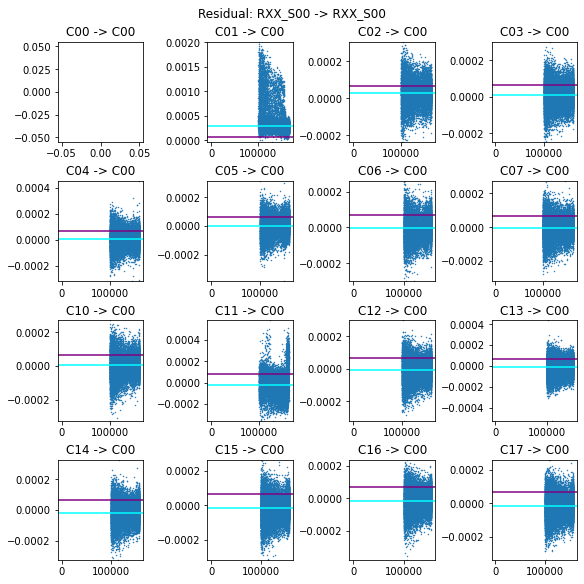

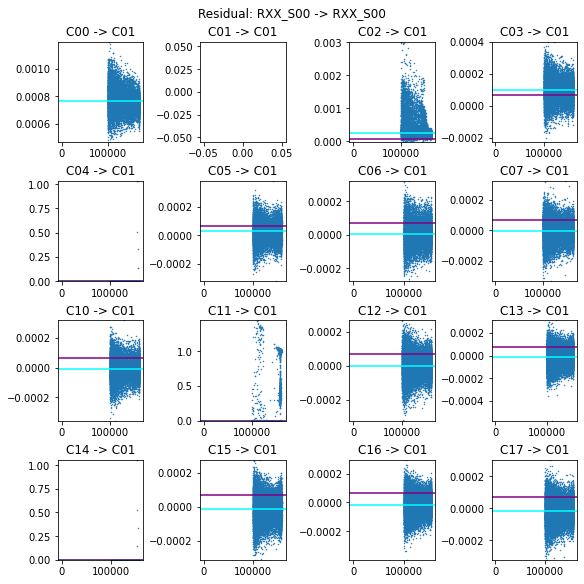

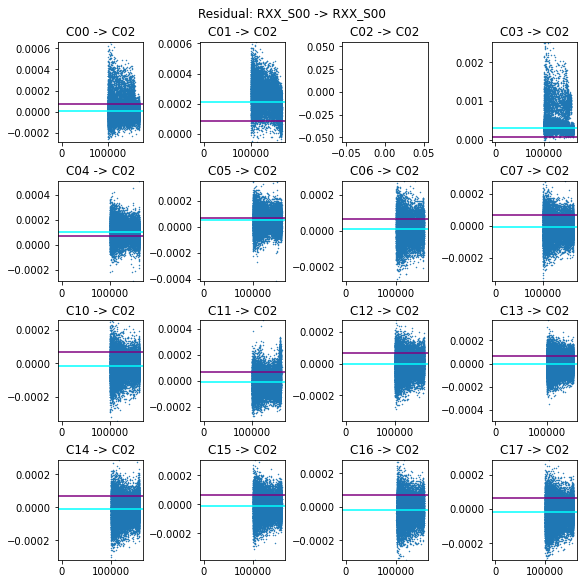

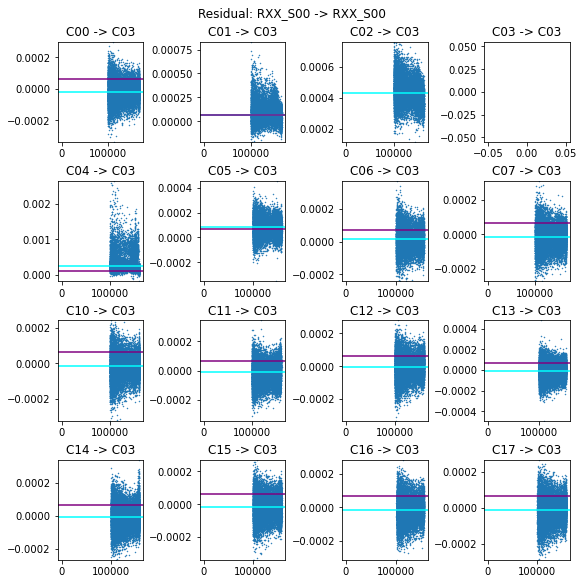

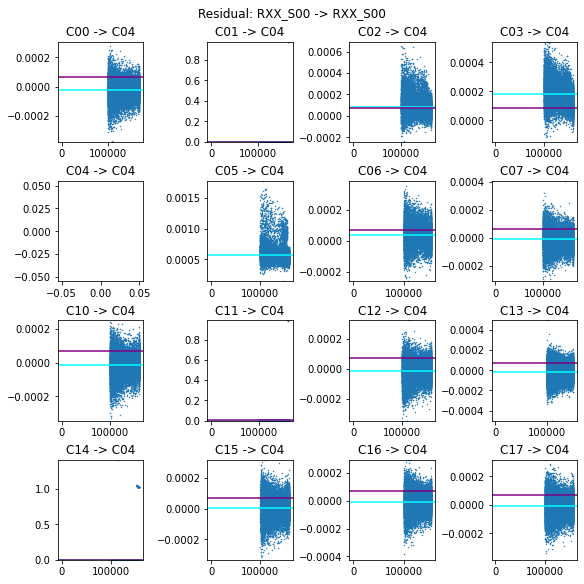

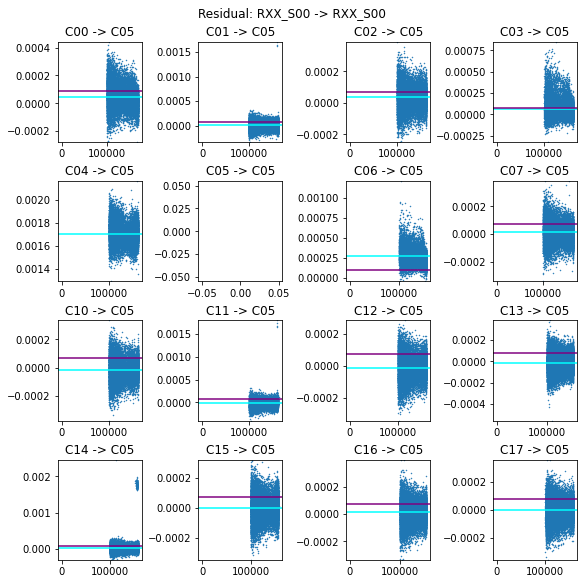

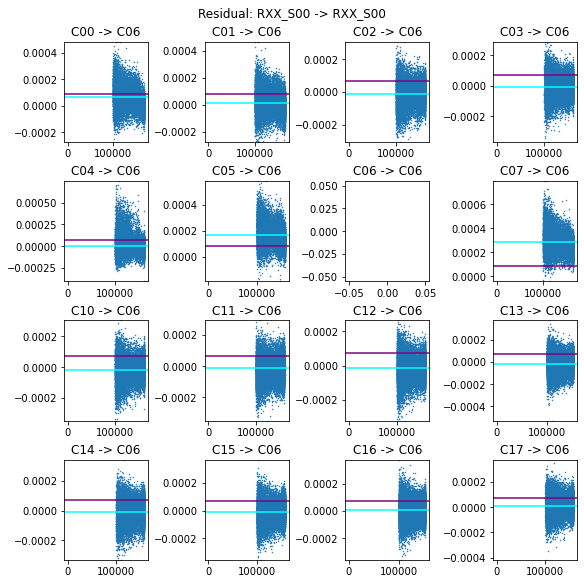

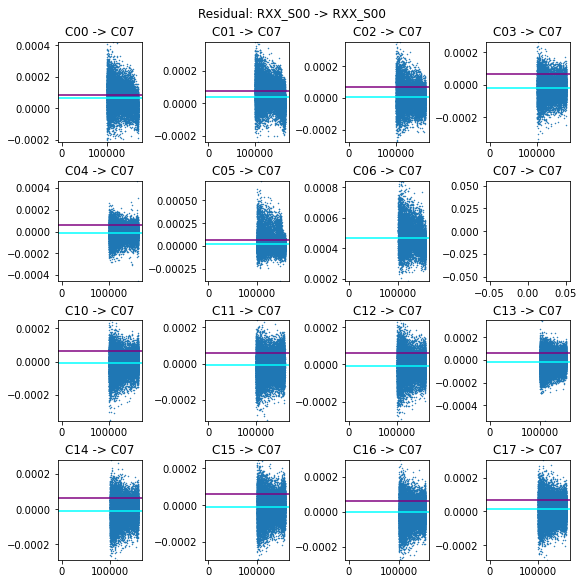

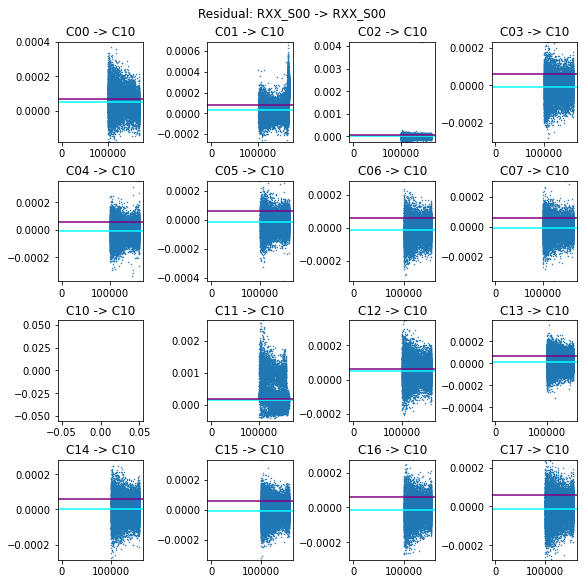

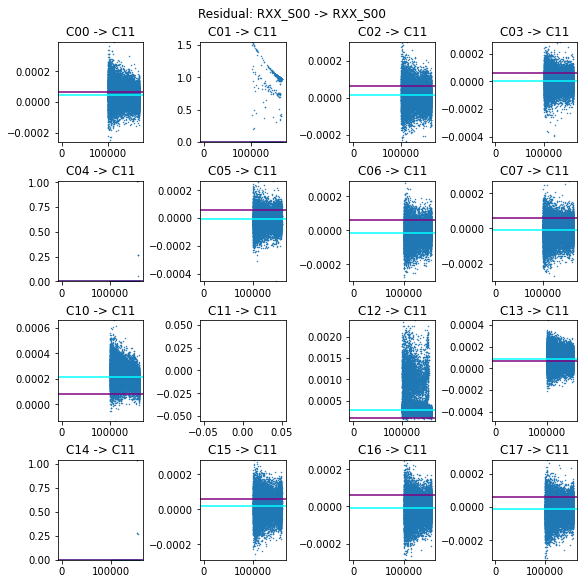

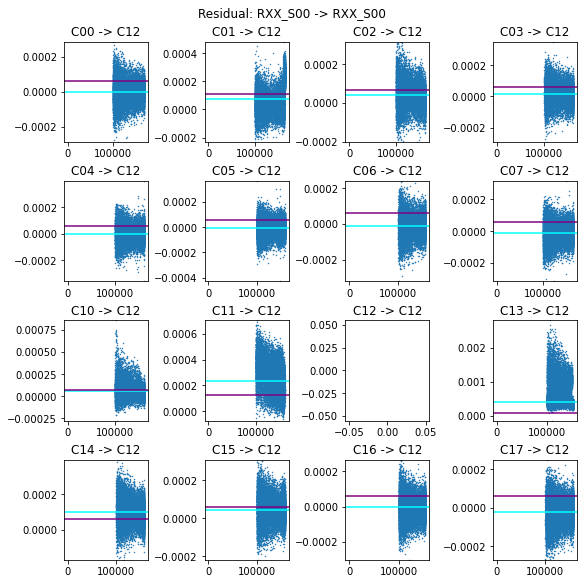

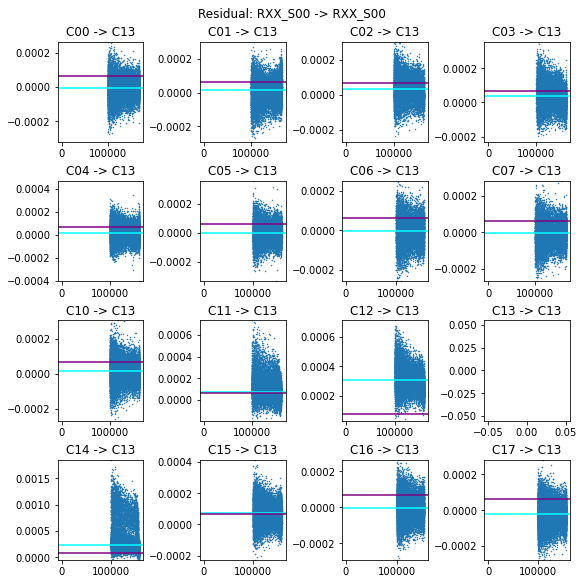

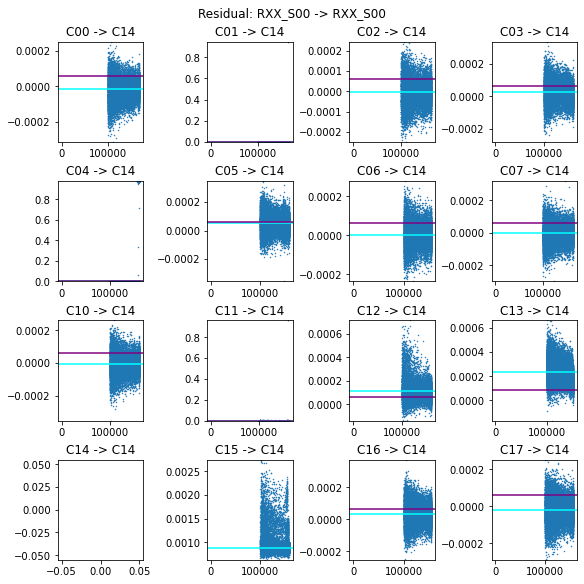

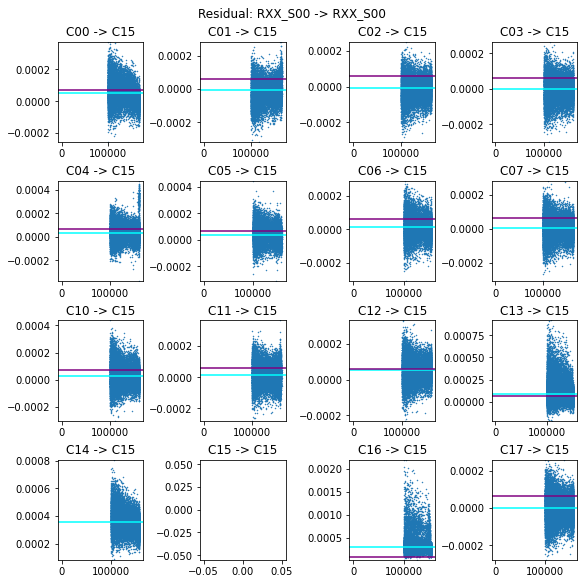

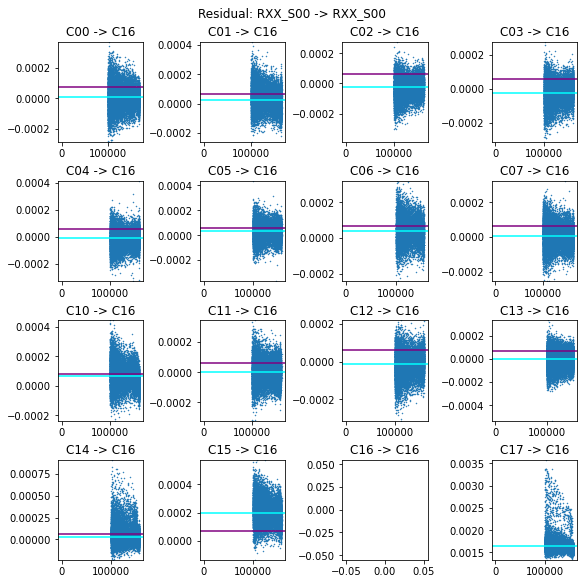

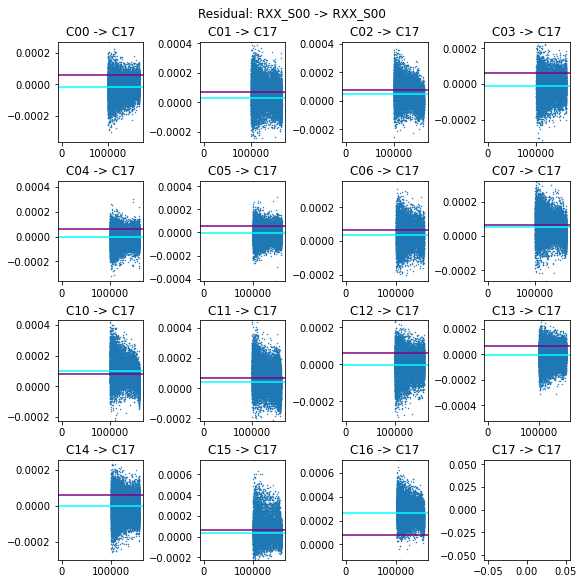

In [16]:
# plot the ratios as a function of flux.
XX = np.arange(-20, -11, 0.1)

for detector in camera:
    ratioDataRefs = butler.registry.queryDatasets('verifyCrosstalkRatio', detector=detector.getId())
    
    for targetAmp, sourceValues in fullSet.items():
        fig, axes = plt.subplots(nrows=4, ncols=4,
                                 sharex=False, sharey=False, figsize=[8.0, 8.0], 
                                 constrained_layout=True)
        axIterator = 0
        for sourceAmp, values in sourceValues.items():
            axTuple = (axIterator // 4, axIterator % 4)
            sourceIt = ordering.index(sourceAmp)
            targetIt = ordering.index(targetAmp)
        
            CTmean = crosstalk.coeffs[targetIt][sourceIt]
            CTerr = crosstalk.coeffErr[targetIt][sourceIt]

            if sourceAmp == targetAmp:
                axes[axTuple].plot([0.0], [0.0])
            else:
                # values = maskValues(fullSet[targetAmp][sourceAmp])
                axes[axTuple].set_ylim(np.min(values), np.max(values))
                # axes[axTuple].set_ylim(-1e-3, 1e-3)
                # axes[axTuple].set_xlim(100000, 170000)
                axes[axTuple].scatter(fluxSet[sourceAmp], 
                                      fullSet[targetAmp][sourceAmp],
                                      s=.1)
                axes[axTuple].axline((0.0, CTmean), slope=0.0, c='cyan')
                axes[axTuple].axline((0.0, CTerr), slope=0.0, c='purple')
            #axes[axIterator // 4, axIterator % 4].hist(residualSet[targetAmp][sourceAmp], bins=25, histtype='step')
            axes[axIterator // 4, axIterator % 4].set_title(f"{sourceAmp} -> {targetAmp}")
            axIterator += 1
        fig.suptitle(f"Residual: {sourceDetector} -> {targetDetector}")
        plt.show()
